<a href="https://colab.research.google.com/github/aps0611/Capegimini-Data-Hackathon/blob/main/Questionnaire_cum_calculations_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

NOTE: Limiting our scope to On-Farm Emissions

# Geocoding the address using Nominatim

In [30]:
from geopy.geocoders import Nominatim

class FarmGeocoder:
    def __init__(self):
        self.geocoder = Nominatim(user_agent="FarmGeocoder")

    def geocode_address(self, address):
        location = self.geocoder.geocode(address)
        if location is not None:
            latitude = location.latitude
            longitude = location.longitude
            return latitude, longitude
        else:
            return None

# Example usage
if __name__ == "__main__":
    farm_addresses = [
        "490 McKinley Maddox, Taylor County",
        "Arrington, KS 66058, Atchison County",
        "Eastern Oregon Franklin Farms"
    ]

    geocoder = FarmGeocoder()

    for address in farm_addresses:
        coordinates = geocoder.geocode_address(address)
        if coordinates is not None:
            latitude, longitude = coordinates
            print(f"Address: {address}")
            print(f"Latitude: {latitude}")
            print(f"Longitude: {longitude}")
            print("---------")
        else:
            print(f"Failed to geocode address: {address}")
            print("---------")

Address: 490 McKinley Maddox, Taylor County
Latitude: 30.1173477
Longitude: -83.6172223
---------
Address: Arrington, KS 66058, Atchison County
Latitude: 39.4627757
Longitude: -95.5363667
---------
Failed to geocode address: Eastern Oregon Franklin Farms
---------


# locate the farms on map

In [31]:
import folium

# Create a Folium map centered on the US
map_us = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Add the two coordinates as markers to the map
coordinates = [
    (30.1173477, -83.6172223),
    (39.4627757, -95.5363667)
]

for coord in coordinates:
    folium.Marker(location=coord).add_to(map_us)

# Display the map
map_us

# Which crop have you plant in last year?

Contraints: Considering the computational cost and time availability we are limiting our scope to 8 crops in US

In [32]:
crop_yield = pd.read_csv('https://raw.githubusercontent.com/aps0611/Capegimini-Data-Hackathon/main/dataset_clean/crop_yield.csv')
crop_yield
# crop yield is in tonnes/Ha

,crops,yield
0,wheat,4.46
1,barley,3.80
2,maize,9.80
3,rice,7.43
4,sorghum,4.96
5,cotton,3.49
6,sugarcane,91.22
7,groundnut,3.72


# creating sample df just for experimentation

* We have to ask user initially what is his total farm size
* Then lets proceed crop by crop
  * for example : which crop is currently planted and area of plantation

In [33]:
# Sample data
data = {
    'Latitude': [30.1173477,39.4627757],
    'Longitude': [-83.6172223,-95.5363667],
    'Area': [30, 100],
    'Crop': ['wheat','rice']
}

# Create dataframe
df = pd.DataFrame(data)

print(df)

    Latitude  Longitude  Area   Crop
0  30.117348 -83.617222    30  wheat
1  39.462776 -95.536367   100   rice


# Which region does users farm belong to?

This particular question is in context of lime usage!!

# Lime

$ Lime use = Area sown(Ha/Farm) * 0.5 (tonne /Ha)$ 

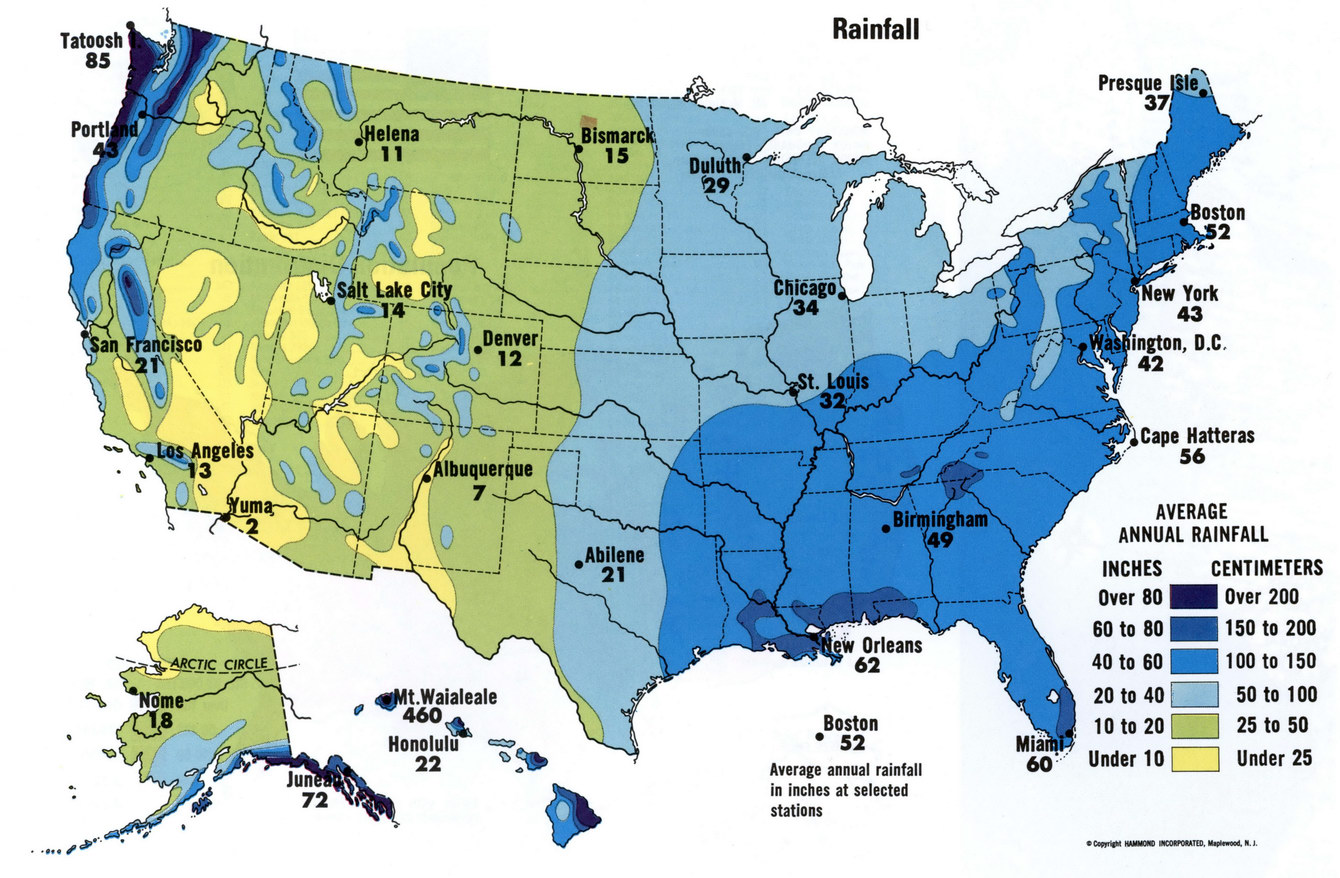



## rainfall is naturally acidic. thus the regions with high rainfall will use more lime to make soil fertile

which region does your farm belong to?

If no lime has been applied in the past year:
* 0.65 * Area

Factor * Area sown: 
* Region 1: 0.55
* Region 2: 0.5
* Region 3: 0.45
* Region 4: 0.45
* Region 5: 0.4
* Region 6 :0.4

Reference: https://content.ces.ncsu.edu/soil-acidity-and-liming-basic-information-for-farmers-and-gardeners

Please note that the data points that we are going to select for our model are going to be categorized region wise

Also, there is correlation between soil-vegetation-rainfall. So, we can select any one of the factor from them and start collecting datapoints

In [34]:
df['Region'] = [1,2]
df

,Latitude,Longitude,Area,Crop,Region
0,30.117348,-83.617222,30,wheat,1
1,39.462776,-95.536367,100,rice,2


In [35]:
df['Lime_usage'] = [0.55*30, 0.50*100]
df

,Latitude,Longitude,Area,Crop,Region,Lime_usage
0,30.117348,-83.617222,30,wheat,1,16.5
1,39.462776,-95.536367,100,rice,2,50.0


# Wheter the user is performing any tillage before planting the crops?

In [36]:
df['tillage'] = ['Yes','Yes']
df

,Latitude,Longitude,Area,Crop,Region,Lime_usage,tillage
0,30.117348,-83.617222,30,wheat,1,16.5,Yes
1,39.462776,-95.536367,100,rice,2,50.0,Yes


# Is the user using any machinery for tillage or plantation?

Here we are assuming that the user is using tractor units: Fuel burnt will release GHG's into the atmosphere.

Farming.  Fortunately, New Holland has an online calculator that allows you to roughly estimate CO2 emissions from its tractor. For example, a modern 300 horsepower Tier 4 tractor operated for 200 hour per year would generate 51,950 lbs of CO2 per year. In metric tonnes, that equals 23.5 tonnes per year. (An older pre-DEF tractor can be calculated on the website too, and not surprisingly, is much worse). A farmer with the modern 300 hp tractor could offset his or her emissions by purchasing 23.5 carbon credits for $179.06 (at today’s price).


In [70]:
23.5/200

0.1175

In [37]:
df['Machinery'] = ['Yes','Yes']
df['Mach_number'] = [1,3]

df

,Latitude,Longitude,Area,Crop,Region,Lime_usage,tillage,Machinery,Mach_number
0,30.117348,-83.617222,30,wheat,1,16.5,Yes,Yes,1
1,39.462776,-95.536367,100,rice,2,50.0,Yes,Yes,3


# Fertilizer Usage:

We can consider giving user 6 options for fertilizers:

1. MAP: Mono-ammonium-phosphate
2. DAP: Di-ammonium-phosphate
3. SOA: Sulphate/Sulphur
4. Urea Application
5. Single Superphosphate
6. UAN: Urea Ammonium Nitrate

In [38]:
df['MAP'] = [0,50]
df['DAP'] = [3,10]
df['SOA'] = [5,5]
df['Urea'] = [2,10]
df ['SSP'] = [1 , 2]
df['UAN'] = [1,5]

df

,Latitude,Longitude,Area,Crop,Region,Lime_usage,tillage,Machinery,Mach_number,MAP,DAP,SOA,Urea,SSP,UAN
0,30.117348,-83.617222,30,wheat,1,16.5,Yes,Yes,1,0,3,5,2,1,1
1,39.462776,-95.536367,100,rice,2,50.0,Yes,Yes,3,50,10,5,10,2,5


# other features we can include in this df

* Electricity consumption for irrigation?
* Whether they are burning any crop residue?
* Leaching or terrain/ TOPOGRAPHY?
* Sequestration
* Land use change

# Calculate the emissions

Few points to make a note of:

1. Largest emissions are from lime usage - CO2
2. Second largest emissions come from urea use - CO2
3. Third largest emittors are usually other fertilizers - N2O
4. Fuel or crop burining- CO2 or N2O
5. Methane emission comes from residue burning

N content of fertiliser	
* MAP	10%
* DAP	18%
* Urea	46%
* SOA	21%
* Urea-Ammonium Nitrate (UAN)	32%
* Ammonium Nitrate (AN)	33.7%
* Calcium Ammonium Nitrate (CAN)	27%


Reference: (Wood & Cowie, 2004)

Annual N2O emissions from the addition of synthetic fertiliser (E)	E = (M x EF x Cg)

M: Amount of synthetic fertilizer applied (in a specific unit, such as kilograms or metric tons of fertilizer).

EF: Emission factor, which represents the amount of N2O emitted per unit of fertilizer applied. It is typically expressed as a percentage. For example, if the EF is 1%, it means that 1% of the applied fertilizer is emitted as N2O.

Cg: Conversion factor, which converts the nitrogen content of the fertilizer to N2O emissions. This factor takes into account the molecular weight and the proportion of nitrogen in N2O.

take Cg as 1.57

Production system |	EF (<600mm rain)	| EF (>600mm rain)|
------------------|-------------------|-----------------|
Non-Irrigated Crop|	0.0005	|0.0085|
Irrigated Crop|	0.0085|	0.0085|
Sugar cane|	0.0199	|0.0199|
Cotton|	0.0055|	0.0055|
Horticulture|	0.0085|	0.0085|

In [39]:
df['N_MAP'] = 0.10 * df['MAP']
df['N_DAP'] = 0.18 * df['DAP']
df['N_SOA'] = 0.21 * df['SOA']
df['N_Urea'] = 0.46 * df['Urea']
df['N_SSP'] = 0.21 * df['SSP']
df['N_UAN'] = 0.32 * df['UAN']

In [44]:
df.columns

Index(['Latitude', 'Longitude', 'Area', 'Crop', 'Region', 'Lime_usage',
       'tillage', 'Machinery', 'Mach_number', 'MAP', 'DAP', 'SOA', 'Urea',
       'SSP', 'UAN', 'N_MAP', 'N_DAP', 'N_SOA', 'N_Urea', 'N_SSP', 'N_UAN'],
      dtype='object')

# calculate the mass of fertilizers:



"Gg N" specifically refers to gigagrams of nitrogen

In [49]:
df['mass_of_fertilizer'] = df['Area'] * (df['N_DAP'] + df['N_MAP'] + df['N_SOA'] + df['N_Urea'] + df['N_SSP'] + df['N_UAN']) * (10**-6)
df

,Latitude,Longitude,Area,Crop,Region,Lime_usage,tillage,Machinery,Mach_number,MAP,...,Urea,SSP,UAN,N_MAP,N_DAP,N_SOA,N_Urea,N_SSP,N_UAN,mass_of_fertilizer
0,30.117348,-83.617222,30,wheat,1,16.5,Yes,Yes,1,0,...,2,1,1,0.0,0.54,1.05,0.92,0.21,0.32,0.000091
1,39.462776,-95.536367,100,rice,2,50.0,Yes,Yes,3,50,...,10,2,5,5.0,1.80,1.05,4.60,0.42,1.60,0.001447


Annual N20 Emiessions

Assume that all crops have irrigation facility

Gas	CO2-e
* CO2	1
* CH4	28
* N2O	265
* CF4	6,630
* C2F6	12,200
* SF6	22,800
* NF3	17,200
	
Gas	Conversion Factor
* CO2	3.67
* CH4	1.33
* N2O	1.57
* Nox	3.29
* CO	2.33
* CO2 Lime	3.67
* NMVOC	1.17

The annual emission is in tonne CO2 equivalent/farm

In [54]:
df['Annual_N2O'] = df['mass_of_fertilizer'] * 0.0085 * 1.57 * (10**3) * 265 

In [55]:
df

,Latitude,Longitude,Area,Crop,Region,Lime_usage,tillage,Machinery,Mach_number,MAP,...,SSP,UAN,N_MAP,N_DAP,N_SOA,N_Urea,N_SSP,N_UAN,mass_of_fertilizer,Annual_N2O
0,30.117348,-83.617222,30,wheat,1,16.5,Yes,Yes,1,0,...,1,1,0.0,0.54,1.05,0.92,0.21,0.32,0.000091,0.322522
1,39.462776,-95.536367,100,rice,2,50.0,Yes,Yes,3,50,...,2,5,5.0,1.80,1.05,4.60,0.42,1.60,0.001447,5.117207


# Caluclate the emissions from lime

In [59]:
fraction_of_limestone = 1
fractional_purity_of_lime = 0.9
fractional_purity_of_dolomite = 0.95
ef_lime = 0.12
ef_dolomite = 0.13
cg = 3.67

In [62]:
df['CO2_lime'] = ((df['Lime_usage'] * fraction_of_limestone * fractional_purity_of_lime * ef_lime) + 
                  (df['Lime_usage'] * (1 - fraction_of_limestone)*fractional_purity_of_lime*ef_lime)) * cg
df

,Latitude,Longitude,Area,Crop,Region,Lime_usage,tillage,Machinery,Mach_number,MAP,...,UAN,N_MAP,N_DAP,N_SOA,N_Urea,N_SSP,N_UAN,mass_of_fertilizer,Annual_N2O,CO2_lime
0,30.117348,-83.617222,30,wheat,1,16.5,Yes,Yes,1,0,...,1,0.0,0.54,1.05,0.92,0.21,0.32,0.000091,0.322522,6.53994
1,39.462776,-95.536367,100,rice,2,50.0,Yes,Yes,3,50,...,5,5.0,1.80,1.05,4.60,0.42,1.60,0.001447,5.117207,19.81800


# emissions from urea application

$M = (M x EF x C)/1000$

In [67]:
ef_urea = 0.20
c_urea = 3.67

In [69]:
df['Urea_CO2'] = df['Urea'] * ef_urea * c_urea
df

,Latitude,Longitude,Area,Crop,Region,Lime_usage,tillage,Machinery,Mach_number,MAP,...,N_MAP,N_DAP,N_SOA,N_Urea,N_SSP,N_UAN,mass_of_fertilizer,Annual_N2O,CO2_lime,Urea_CO2
0,30.117348,-83.617222,30,wheat,1,16.5,Yes,Yes,1,0,...,0.0,0.54,1.05,0.92,0.21,0.32,0.000091,0.322522,6.53994,1.468
1,39.462776,-95.536367,100,rice,2,50.0,Yes,Yes,3,50,...,5.0,1.80,1.05,4.60,0.42,1.60,0.001447,5.117207,19.81800,7.340


# emissions from machinery

1 tractor of 300 Horse power operating 200 Hr per year generates rougly 21 CO2t equivalent

One more input how many hours are we operating the machine

In [72]:
df['Total_emissions'] = df['Annual_N2O'] + df['CO2_lime'] + df['Urea_CO2']

In [73]:
df

,Latitude,Longitude,Area,Crop,Region,Lime_usage,tillage,Machinery,Mach_number,MAP,...,N_DAP,N_SOA,N_Urea,N_SSP,N_UAN,mass_of_fertilizer,Annual_N2O,CO2_lime,Urea_CO2,Total_emissions
0,30.117348,-83.617222,30,wheat,1,16.5,Yes,Yes,1,0,...,0.54,1.05,0.92,0.21,0.32,0.000091,0.322522,6.53994,1.468,8.330462
1,39.462776,-95.536367,100,rice,2,50.0,Yes,Yes,3,50,...,1.80,1.05,4.60,0.42,1.60,0.001447,5.117207,19.81800,7.340,32.275207
